## Improved dealiasing notebook

In [156]:
import pyart
import cartopy.crs as ccrs
import pandas
from scipy import signal
from copy import deepcopy
from netCDF4 import Dataset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff', 'norm', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Case 1: ARMOUR radar example

In [157]:
armour_file_path = '/home/rjackson/dealias/data/RAW_NA_000_125_20110427193816'
sounding_path = '/home/rjackson/dealias/data/armour_sounding.txt'
radar_armour = pyart.io.read(armour_file_path)
radar_armour.info()
radar_armour.instrument_parameters['prt']['data']

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	positive: up
	standard_name: Altitude
	units: meters
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (1365,)>
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
	standard_name: beam_azimuth_angle
	units: degrees
elevation:
	data: <ndarray of type: float32 and shape: (1365,)>
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
	standard_name: beam_elevation_angle
	units: degrees
fields:
	reflectivity:
		data: <ndarray of type: float32 and shape: (1365, 992)>
		long_name: Reflectivity
		coordinates: elevation azimuth range
		standard_name: equivalent_reflectivity_factor
		units: dBZ
		_FillValue: -9999.0
	differential_phase:
		data: <ndarray of type: float32 and shape: (1365, 992)>
		long_

/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/sigmet.py:141: RuntimeWarning: invalid value encountered in sqrt
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


array([ 0.00083333,  0.00083333,  0.00083333, ...,  0.00083333,
        0.00083333,  0.00083333], dtype=float32)

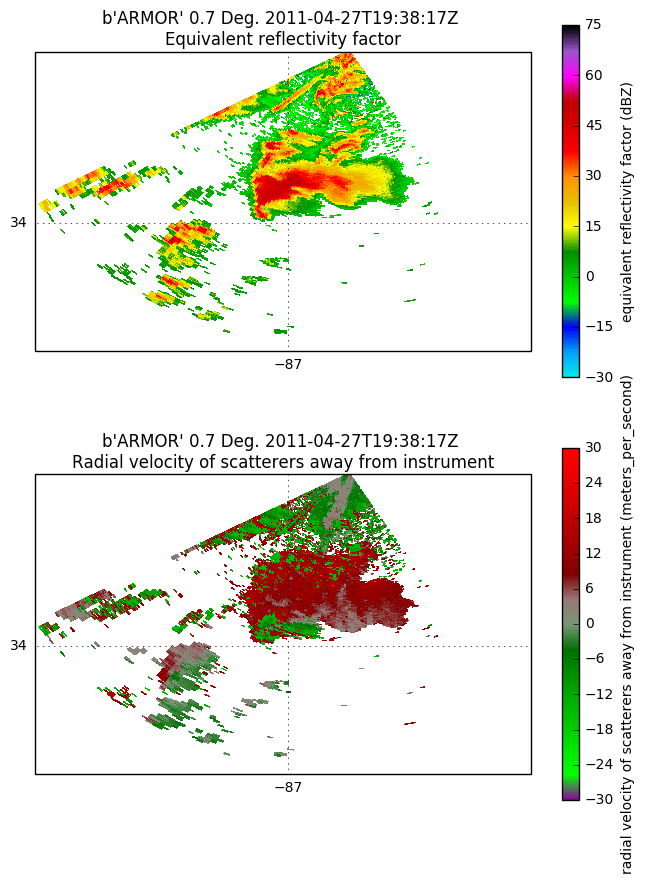

In [158]:
plt.figure(figsize=(8,10))
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplayCartopy(radar_armour)
display.plot_ppi_map('reflectivity', cmap=pyart.graph.cm.NWSRef, ax=ax1, resolution='10m')
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
display.plot_ppi_map('velocity', cmap=pyart.graph.cm.NWSVel, ax=ax2, resolution='10m')

Index(['PRES', 'HGHT', 'TEMP', 'DWPT', 'RELH', 'MIXR', 'DRCT', 'SKNT', 'THTA',
       'THTE', 'THTV'],
      dtype='object')


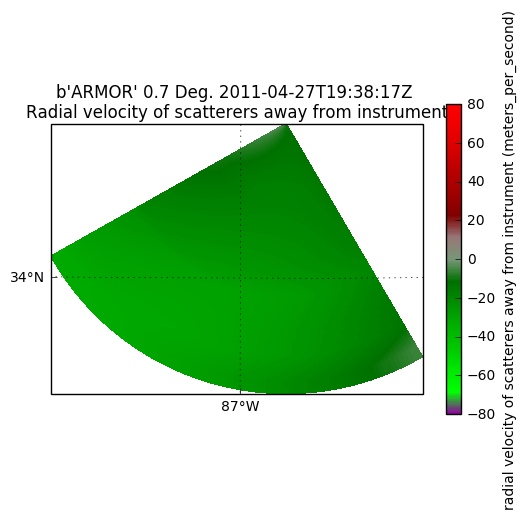

In [159]:
## Load sounding
sounding = pandas.read_csv(sounding_path, delim_whitespace=True, header=0)
print(sounding.keys())
z = sounding['HGHT'].values
direction = sounding['DRCT'].values
# Load speeds and convert from kt to m/s
speed = sounding['SKNT'].values*0.514444
profile = pyart.core.HorizontalWindProfile(z, speed, direction)
sim_vel = pyart.util.simulated_vel.simulated_vel_from_profile(radar_armour, profile)
radar_armour.add_field('sim_velocity', sim_vel, replace_existing=True)
display.plot_ppi_map('sim_velocity', cmap=pyart.graph.cm.NWSVel, resolution='10m', vmin=-80, vmax=80)

/home/rjackson/.local/lib/python3.5/site-packages/pyart/util/sigmath.py:62: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi


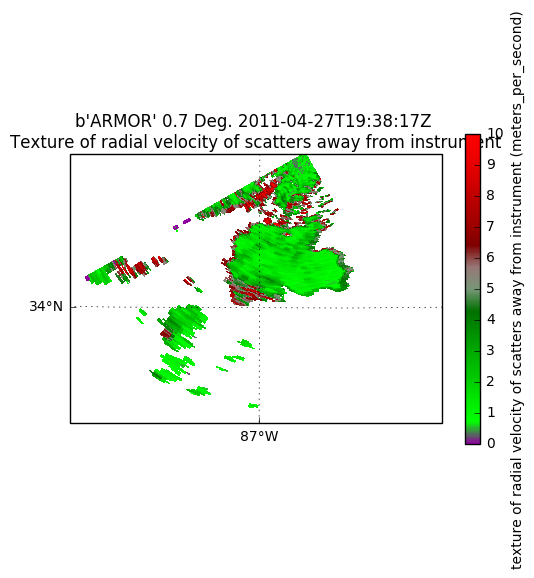

In [160]:
## Gatefilter
texture_field = pyart.retrieve.calculate_velocity_texture(radar_armour)
radar_armour.add_field('velocity_texture', texture_field, replace_existing=True)
gatefilter = pyart.correct.despeckle.despeckle_field(radar_armour, 'velocity')
gatefilter.exclude_masked('velocity')
display.plot_ppi_map('velocity_texture', cmap=pyart.graph.cm.NWSVel, resolution='10m', 
                     gatefilter=gatefilter,vmin=0, vmax=10)

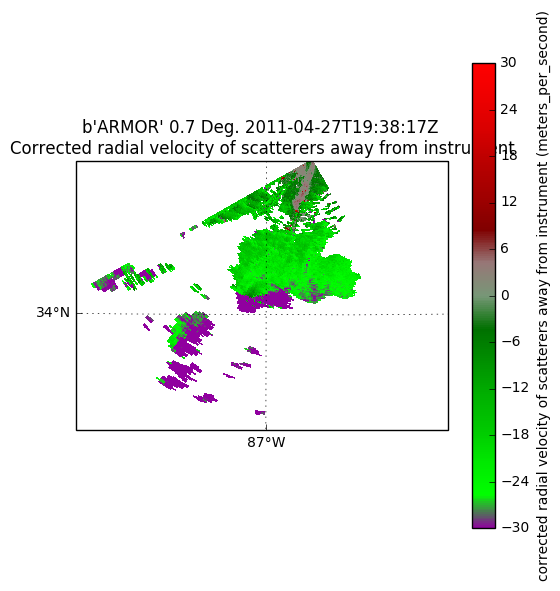

In [161]:
## Region based dealiasing (based off my CPOL settings)
corrected_velocity_region = pyart.correct.dealias_region_based(radar_armour,
                                                               ref_vel_field='sim_velocity',
                                                               gatefilter=gatefilter,
                                                               keep_original=False,
                                                               centered=True,
                                                               interval_splits=6,
                                                               skip_between_rays=2000,
                                                               wrap_around_rays=True,
                                                               )
        
radar_armour.add_field('corrected_velocity_region', corrected_velocity_region,
                       replace_existing=True)
plt.figure(figsize=(6,6))
display.plot_ppi_map('corrected_velocity_region', cmap=pyart.graph.cm.NWSVel, resolution='10m', sweep=0,
                     vmin=-30, vmax=30)

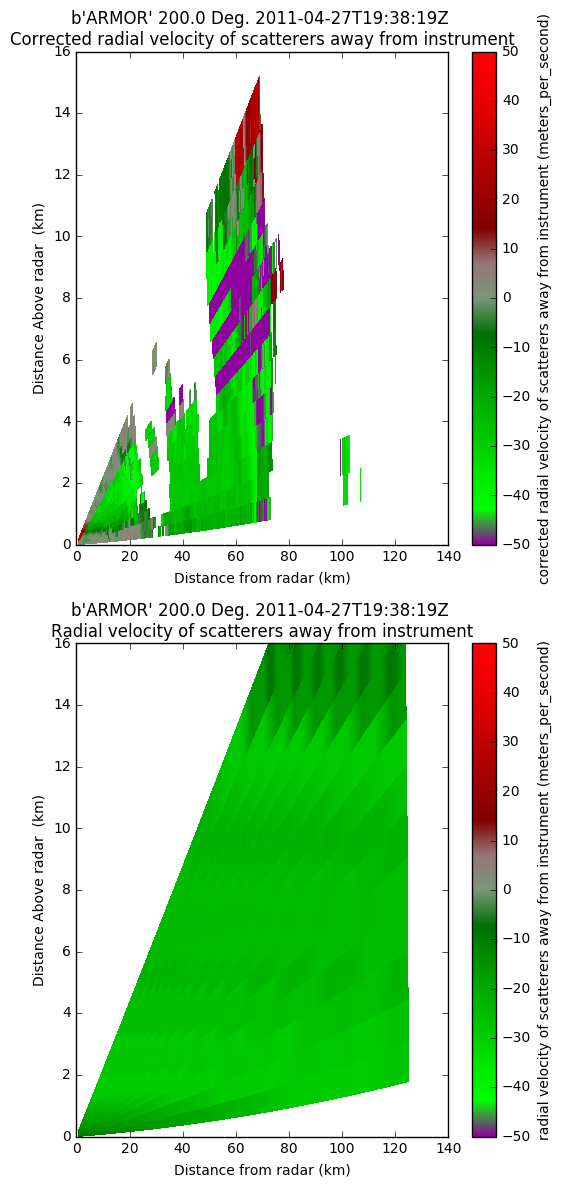

In [162]:
xsect = pyart.util.cross_section_ppi(radar_armour, [200])

gr = pyart.graph.RadarDisplay(xsect)
fig, ax = plt.subplots(2, 1, figsize=(6, 14))
# ax = ax.flatten()

gr.plot('corrected_velocity_region', 0, cmap='pyart_NWSVel', vmin=-50, vmax=50, ax=ax[0])
gr.plot('sim_velocity', 0, cmap='pyart_NWSVel', vmin=-50, vmax=50, ax=ax[1])
for myax in ax:
    myax.set_ylim(0, 16)

16.08


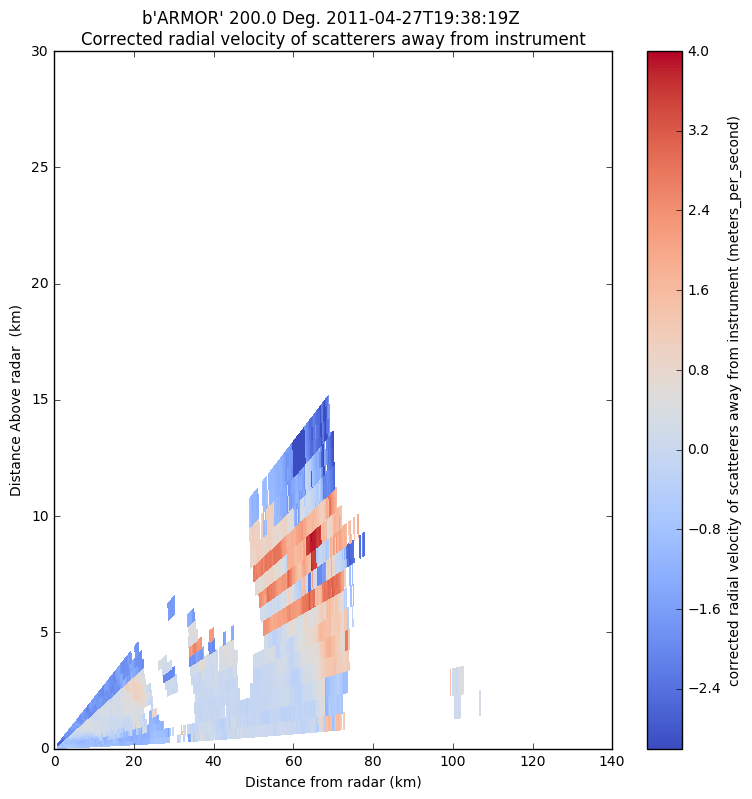

In [163]:
nyq = radar_armour.instrument_parameters['nyquist_velocity']['data'][0]
print(nyq)
diff = (radar_armour.fields['sim_velocity']['data']-radar_armour.fields['corrected_velocity_region']['data'])/(nyq)
radar_armour.add_field_like('corrected_velocity_region', 'difference', diff, replace_existing=True)
plt.figure(figsize=(9,9))
xsect = pyart.util.cross_section_ppi(radar_armour, [200])
gr = pyart.graph.RadarDisplay(xsect)
gr.plot('difference', 0, cmap='coolwarm', vmin=-3, vmax=4)

[]
[]
[-3.304 -1.736  0.168  2.128]


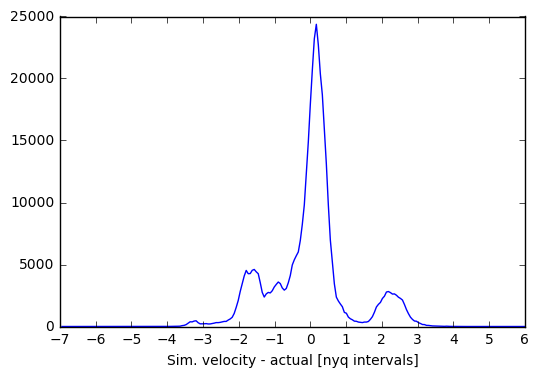

In [167]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def angular_mean_2d(image, N, interval):
    """
    Compute the angular texture of an image. Uses convolutions
    in order to speed up texture calculation by a factor of ~50
    compared to using ndimage.generic_filter

    Parameters
    ----------
    image : 2D array of floats
        The array containing the velocities in which to calculate
        texture from.
    N : int
        This is the window size for calculating texture. The texture will be 
        calculated from an N by N window centered around the gate.
    interval : float
        The absolute value of the maximum velocity. In conversion to
        radial coordinates, pi will be defined to be interval
        and -pi will be -interval. It is recommended that interval be
        set to the Nyquist velocity.

    Returns
    -------
    std_dev : float array
        Texture of the radial velocity field.

    """

    # transform distribution from original interval to [-pi, pi]
    interval_max = interval
    interval_min = -interval
    half_width = (interval_max - interval_min) / 2.
    center = interval_min + half_width

    # Calculate parameters needed for angular std. dev
    im = (np.asarray(image) - center) / (half_width) * np.pi
    x = np.cos(im)
    y = np.sin(im)

    # Calculate convolution
    kernel = np.ones((N, N))
    xs = signal.convolve2d(x, kernel, mode="same", boundary="symm")
    ys = signal.convolve2d(y, kernel, mode="same", boundary="symm")
    ns = N**2

    # Calculate norm over specified window
    xmean = xs/ns
    ymean = ys/ns
    ang_mean = np.arctan2(ymean, xmean)
    return ang_mean

diff_ang = angular_mean_2d(diff, 5, nyq)

nyq_bins = np.arange(-7, 7, 0.05)
gfilter = gatefilter.gate_excluded
diff_hist, bins = np.histogram(diff[~gfilter], bins=250, range=[-7,7])
plt.plot(bins[1:], diff_hist)
plt.xlim([-5, 5])
plt.xticks(range(-7,7))
plt.xlabel('Sim. velocity - actual [nyq intervals]')
peakind = signal.find_peaks_cwt(diff_hist, np.array([3]))
diff_by_integer = abs(np.round(bins[peakind])-bins[peakind])
peak_values = bins[peakind]
plt.scatter(peak_values[off_by_integer],5000*np.ones(peak_values[off_by_integer].shape))
print(np.round(peak_values[off_by_integer]))
print(peak_values[off_by_integer])
print(peak_values)

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


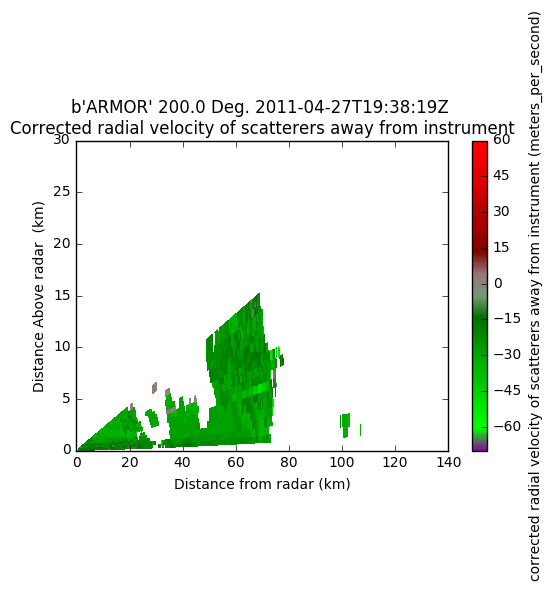

In [168]:
gfilter = gatefilter.gate_excluded
vels = deepcopy(radar_armour.fields['corrected_velocity_region']['data'])
vels_uncorr = radar_armour.fields['velocity']['data']
region_means = []
regions = np.zeros(vels.shape)
for nsweep, sweep_slice in enumerate(radar_armour.iter_slice()):
    sfilter = gfilter[sweep_slice]
    diffs_slice = diff[sweep_slice]
    vels_slice = vels[sweep_slice]
    vels_uncorrs = vels_uncorr[sweep_slice]
    valid_sdata = vels_uncorrs[~sfilter]
    int_splits = pyart.correct.region_dealias._find_sweep_interval_splits(
        nyq, 3, valid_sdata, nsweep)
    regions[sweep_slice], nfeatures = pyart.correct.region_dealias._find_regions(diffs_slice, sfilter, 
                                                                                 limits=int_splits)

    for reg in np.unique(regions[sweep_slice]):
        reg_mean = np.mean(diffs_slice[regions[sweep_slice] == reg])
        region_means.append(reg_mean)
        for integers in np.round(peak_values):
            if(reg_mean > integers-0.3 and reg_mean < integers+0.3):
                vels_slice[regions[sweep_slice] == reg] = (vels_slice[regions[sweep_slice] == reg] + 
                                                          (nyq)*np.round(diffs_slice[regions[sweep_slice] == reg]))
    vels[sweep_slice] = vels_slice
#    if(nsweep > 0):
#        regions = np.where(np.logical_and(diff_slice - prev_slice)     
#        vels[sweep_slice] = vels[sweep_slice] + regions*nyq    
#    prev_slice = deepcopy(diff_slice)
#    prev_sweep = sweep_slice
   
radar_armour.add_field_like('corrected_velocity_region', 'corrected_velocity_region_improved', 
                            vels, replace_existing=True)

xsect = pyart.util.cross_section_ppi(radar_armour, [200])
gr = pyart.graph.RadarDisplay(xsect)
gr.plot('corrected_velocity_region_improved', 0, cmap='pyart_NWSVel', vmin=-70, vmax=60)

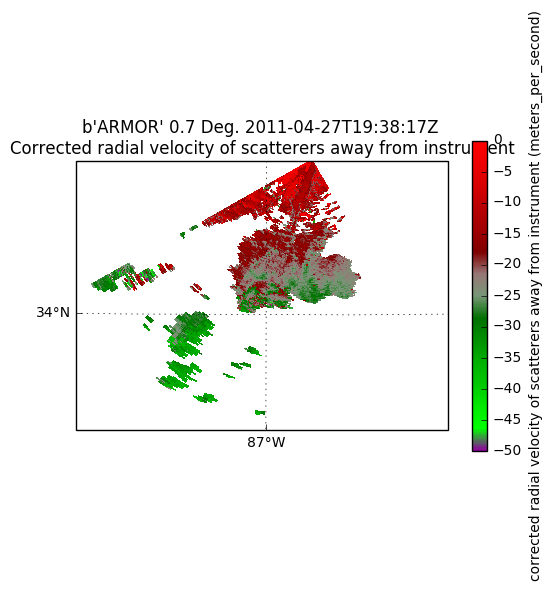

In [170]:
display.plot_ppi_map('corrected_velocity_region_improved', cmap=pyart.graph.cm.NWSVel, resolution='10m', sweep=0,
                     vmin=-50, vmax=0)

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


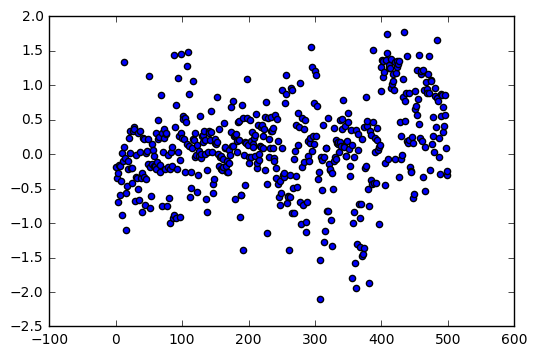

In [135]:
plt.scatter(range(500), region_means[0:500])

In [136]:
cpol_file_name = '/home/rjackson/data/radar/cpol/Gunn_pt_20060120005000_PPI_deal.uf'
sounding_cpol_name = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060119.231600.custom.cdf'


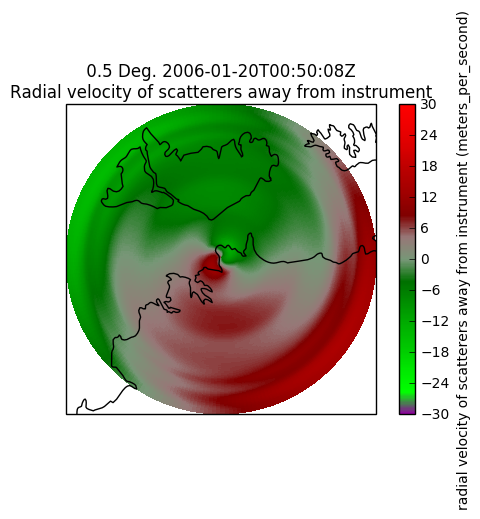

In [137]:
radar_cpol = pyart.io.read(cpol_file_name)
sounding_cpol = Dataset(sounding_cpol_name)
sounding_cpol.variables.keys()
z = sounding_cpol.variables['alt'][:]
speed = sounding_cpol.variables['wspd'][:]
deg = sounding_cpol.variables['deg'][:]
profile = pyart.core.HorizontalWindProfile(z, speed, deg)
sim_vel = pyart.util.simulated_vel.simulated_vel_from_profile(radar_cpol, profile)
display = pyart.graph.RadarMapDisplayCartopy(radar_cpol)
radar_cpol.add_field('sim_velocity', sim_vel, replace_existing=True)
display.plot_ppi_map('sim_velocity', cmap=pyart.graph.cm.NWSVel, resolution='10m', vmin=-30, vmax=30)

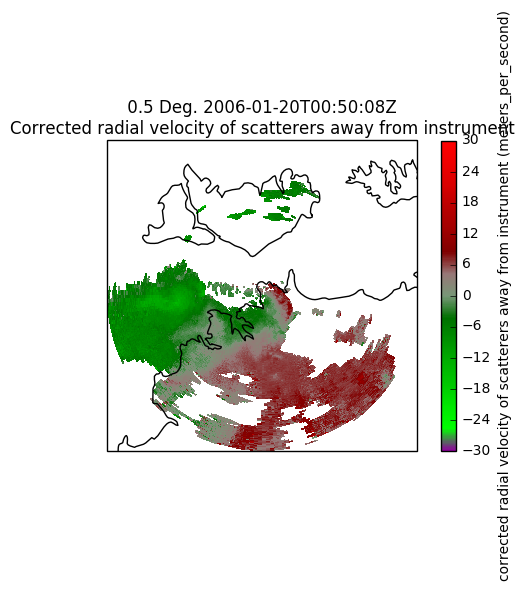

In [138]:
nyq_cpol = radar_cpol.instrument_parameters['nyquist_velocity']['data'][0]
texture = pyart.retrieve.calculate_velocity_texture(radar_cpol, 'velocity', 4, nyq_cpol)
radar_cpol.add_field('velocity_texture', texture, replace_existing=True)
gatefilter_cpol = pyart.filters.GateFilter(radar_cpol)
gatefilter_cpol.exclude_above('velocity_texture', 3)
gatefilter_cpol.exclude_invalid('corrected_velocity')
display.plot_ppi_map('corrected_velocity', cmap=pyart.graph.cm.NWSVel, resolution='10m', vmin=-30, vmax=30,
                     gatefilter=gatefilter_cpol)

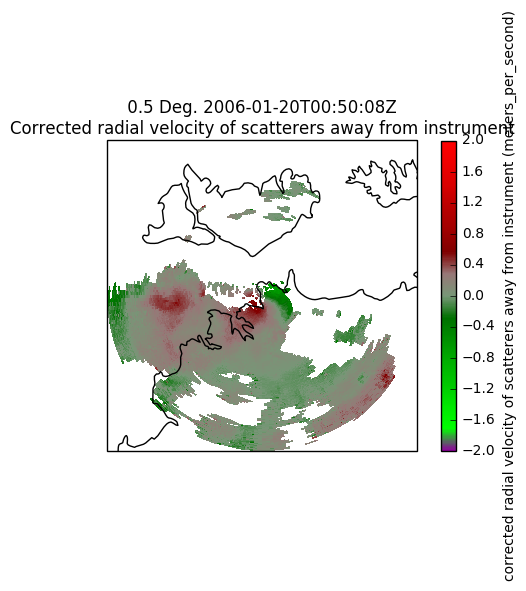

In [139]:
diff = (radar_cpol.fields['sim_velocity']['data']-radar_cpol.fields['corrected_velocity']['data'])/(2*nyq_cpol)
radar_cpol.add_field_like('corrected_velocity', 'difference', diff, replace_existing=True)
display.plot_ppi_map('difference', cmap=pyart.graph.cm.NWSVel, resolution='10m', vmin=-2, vmax=2,
                     gatefilter=gatefilter_cpol)

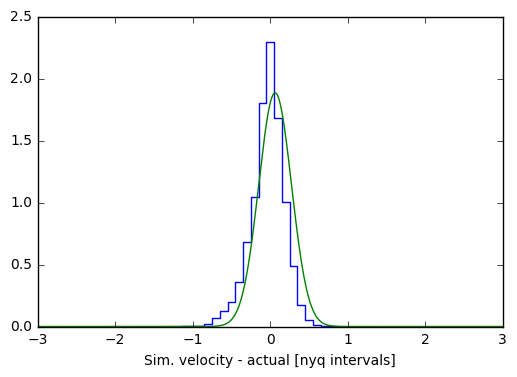

In [140]:
from scipy.stats import norm
gfilter = gatefilter_cpol.gate_excluded
nyq_bins = np.arange(-nyq_cpol, nyq_cpol, 0.1)
means,stds=norm.fit(diff[~gfilter])
diff_hist, bins = np.histogram(diff[~gfilter], bins=nyq_bins)
plt.step(bins[:-1], diff_hist/np.sum(diff_hist)/0.1)
x = np.arange(-3,3,0.001)
plt.plot(x, norm.pdf(x, means, stds))
plt.xlim([-3, 3])
plt.xlabel('Sim. velocity - actual [nyq intervals]')

In [176]:
paloma_file_name = '/home/rjackson/csaprrhiI7.00/rhi/20110523/234251.mdv'
sounding_file_name_paloma = '/home/rjackson/csaprrhiI7.00/rhi/sgpsondewnpnC1.b1.20110523.201900.cdf'

(0, 20)

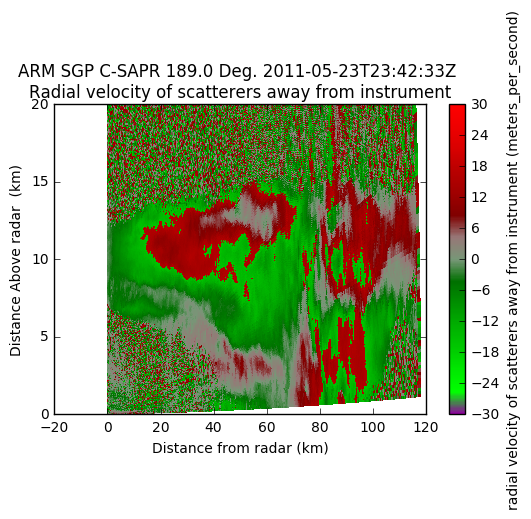

In [177]:
radar_paloma = pyart.io.read(paloma_file_name)
display = pyart.graph.RadarMapDisplay(radar_paloma)
display.plot_rhi('velocity', cmap=pyart.graph.cm.NWSVel, vmin=-30, vmax=30)
plt.ylim([0,20])

(0, 20)

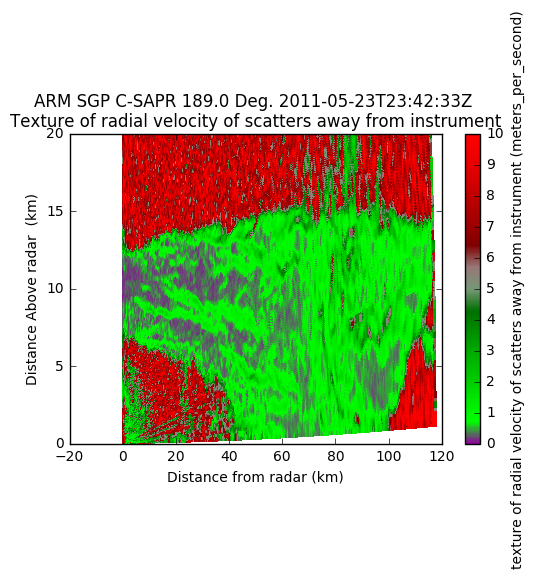

In [181]:
texture_field = pyart.retrieve.calculate_velocity_texture(radar_paloma)
radar_paloma.add_field('velocity_texture', texture_field, replace_existing=True)
gatefilter = pyart.correct.despeckle.despeckle_field(radar_paloma, 'velocity')
gatefilter.exclude_masked('velocity')
gatefilter.exclude_invalid('velocity')
gatefilter.exclude_above('velocity_texture', 5)
display.plot_rhi('velocity_texture', cmap=pyart.graph.cm.NWSVel,  
                 vmin=0, vmax=10)
plt.ylim([0,20])

/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


(0, 20)

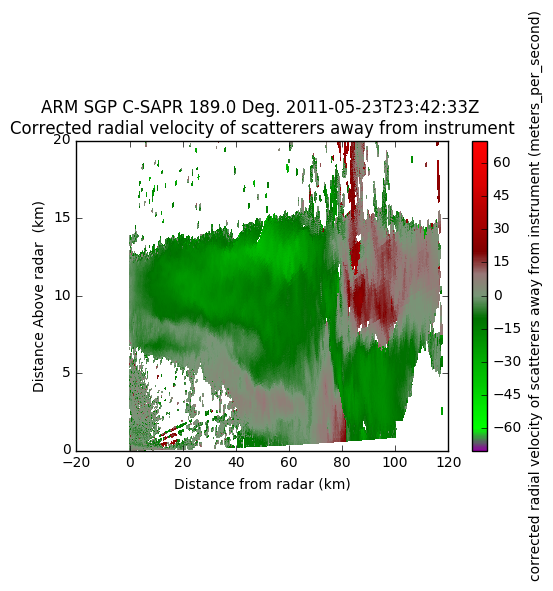

In [232]:
corrected_velocity_region = pyart.correct.dealias_region_based(radar_paloma,
                                                               gatefilter=gatefilter,
                                                               keep_original=False,
                                                               interval_splits=10,
                                                               skip_between_rays=2000,
                                                               )
radar_paloma.add_field('corrected_velocity_region', corrected_velocity_region,
                       replace_existing=True)
display.plot_rhi('corrected_velocity_region', cmap=pyart.graph.cm.NWSVel,  
                 gatefilter=gatefilter,vmin=-70, vmax=70)
plt.ylim([0,20])

odict_keys(['base_time', 'time_offset', 'time', 'qc_time', 'pres', 'qc_pres', 'tdry', 'qc_tdry', 'dp', 'qc_dp', 'wspd', 'qc_wspd', 'deg', 'qc_deg', 'rh', 'qc_rh', 'u_wind', 'qc_u_wind', 'v_wind', 'qc_v_wind', 'wstat', 'asc', 'qc_asc', 'lat', 'lon', 'alt'])


(0, 20)

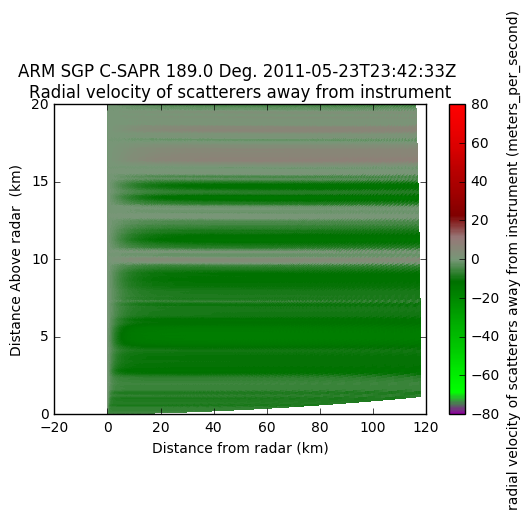

In [183]:
from netCDF4 import Dataset
sounding = Dataset(sounding_file_name_paloma)
print(sounding.variables.keys())
z = sounding.variables['alt'][:]
speed = sounding.variables['wspd'][:]
deg = sounding.variables['deg'][:]
profile = pyart.core.HorizontalWindProfile(z, speed, deg)
sim_vel = pyart.util.simulated_vel.simulated_vel_from_profile(radar_paloma, profile)
radar_paloma.add_field('sim_velocity', sim_vel, replace_existing=True)
display.plot_rhi('sim_velocity', cmap=pyart.graph.cm.NWSVel, vmin=-80, vmax=80)
plt.ylim([0,20])

16.526


(0, 20)

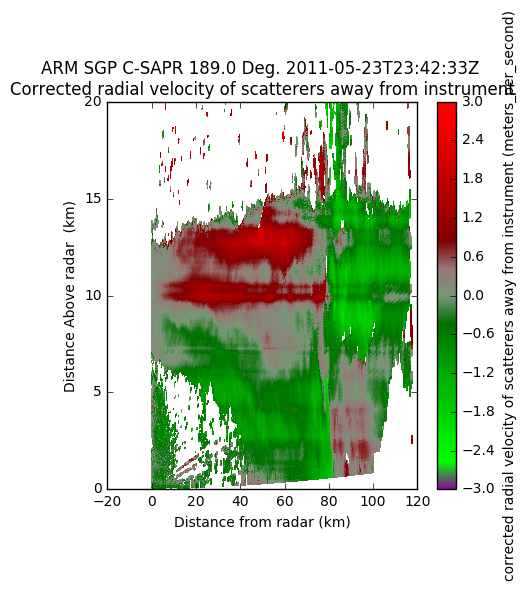

In [222]:
nyq = radar_paloma.instrument_parameters['nyquist_velocity']['data'][0]
print(nyq)
diff = (radar_paloma.fields['sim_velocity']['data']-radar_paloma.fields['corrected_velocity_region']['data'])/(nyq)
radar_paloma.add_field_like('corrected_velocity_region', 'difference', diff, replace_existing=True)
plt.figure(figsize=(5,5))
display.plot_rhi('difference', cmap=pyart.graph.cm.NWSVel, vmin=-3, vmax=3)
plt.ylim([0,20])

[-1. -0.  1.  2.]


/home/rjackson/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/rjackson/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


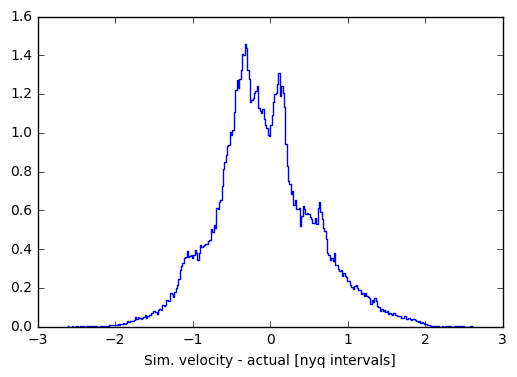

In [228]:
from scipy.stats import norm
gfilter = gatefilter.gate_excluded
means,stds=norm.fit(diff[~gfilter])
diff_hist, bins = np.histogram(diff[np.logical_and(~gfilter, np.isfinite(diff))], bins=300)
peakind = signal.find_peaks_cwt(diff_hist, np.array([5]))
peak_values = bins[peakind]
plt.step(bins[:-1], diff_hist/np.sum(diff_hist)/0.01)
x = np.arange(-3, 3, 0.001)
plt.plot(x, norm.pdf(x, means, stds))
plt.xlim([-3, 3])
plt.xlabel('Sim. velocity - actual [nyq intervals]')
print(np.unique(np.round(bins[peakind])))

16.526


(0, 20)

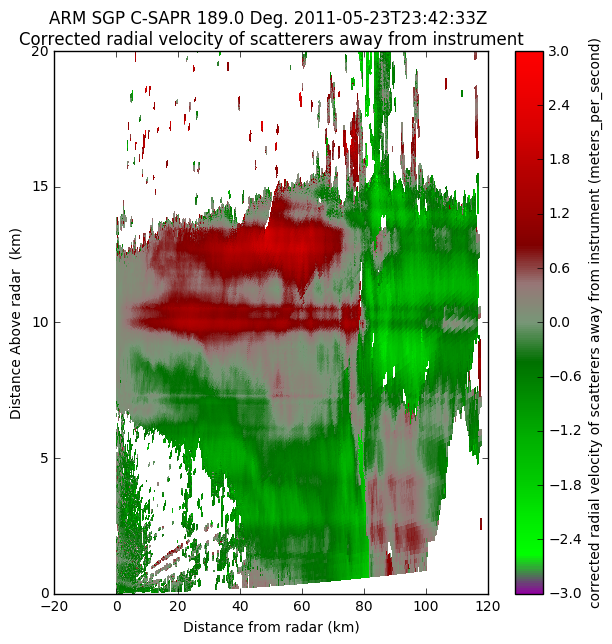

In [224]:
nyq = radar_paloma.instrument_parameters['nyquist_velocity']['data'][0]
print(nyq)
diff = (radar_paloma.fields['sim_velocity']['data']-radar_paloma.fields['corrected_velocity_region']['data'])/(nyq)
radar_paloma.add_field_like('corrected_velocity_region', 'difference', diff, replace_existing=True)
plt.figure(figsize=(7,7))
display.plot_rhi('difference', cmap=pyart.graph.cm.NWSVel, vmin=-3, vmax=3)
plt.ylim([0,20])

/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)
/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/region_dealias.py:314: RuntimeWarning: invalid value encountered in greater_equal
  inp = (lmin <= vel) & (vel < lmax) & mask
/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/region_dealias.py:314: RuntimeWarning: invalid value encountered in less
  inp = (lmin <= vel) & (vel < lmax) & mask
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask

(0, 20)

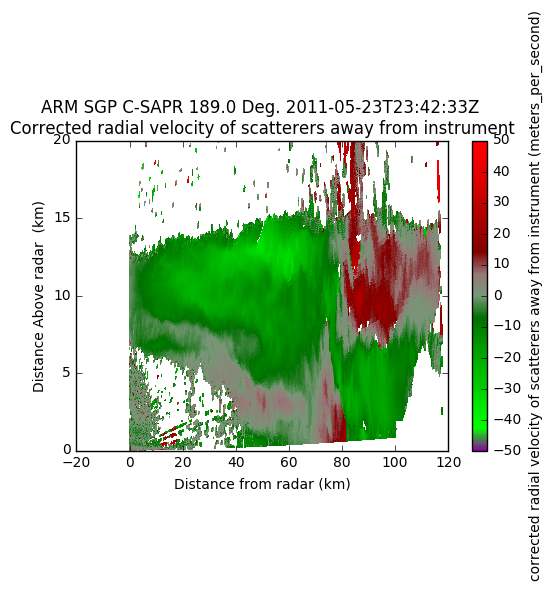

In [233]:
gfilter = gatefilter.gate_excluded
vels = deepcopy(radar_paloma.fields['corrected_velocity_region']['data'])
vels_uncorr = radar_paloma.fields['velocity']['data']
region_means = []
regions = np.zeros(vels.shape)
for nsweep, sweep_slice in enumerate(radar_paloma.iter_slice()):
    sfilter = gfilter[sweep_slice]
    diffs_slice = diff[sweep_slice]
    vels_slice = vels[sweep_slice]
    vels_uncorrs = vels_uncorr[sweep_slice]
    valid_sdata = vels_uncorrs[~sfilter]
    int_splits = pyart.correct.region_dealias._find_sweep_interval_splits(
        nyq, 10, valid_sdata, nsweep)
    regions[sweep_slice], nfeatures = pyart.correct.region_dealias._find_regions(diffs_slice, sfilter, 
                                                                                 limits=int_splits)

    for reg in np.unique(regions[sweep_slice]):
        reg_mean = np.median(diffs_slice[regions[sweep_slice] == reg])
        region_means.append(reg_mean)
        for integers in np.unique(np.round(bins[peakind])):
            if(reg_mean > integers-0.3 and reg_mean < integers+0.3):
                vels_slice[regions[sweep_slice] == reg] = (vels_slice[regions[sweep_slice] == reg] + 
                                                          (nyq)*integers)
    vels[sweep_slice] = vels_slice
#    if(nsweep > 0):
#        regions = np.where(np.logical_and(diff_slice - prev_slice)     
#        vels[sweep_slice] = vels[sweep_slice] + regions*nyq    
#    prev_slice = deepcopy(diff_slice)
#    prev_sweep = sweep_slice
   
radar_paloma.add_field_like('corrected_velocity_region', 'corrected_velocity_region_improved', 
                            vels, replace_existing=True)

display.plot_rhi('corrected_velocity_region_improved', cmap=pyart.graph.cm.NWSVel, vmin=-50, vmax=50)
plt.ylim([0,20])